# Vocabulary and bias analysis

The aim of this notebook is to perform some basic analysis on the vocabulary set of both 8K and 30K image captions. We want to analyze a few things:
* Word frequencies - how frequently words repeat + which words are most common
* Distribution of POS 
* Color distribution (use embeddings to sort into a limited group of colors)
* Gender distribution (use embeddings to get a tone?)
* Age distribution (use embeddings)
* Name-entity recognition/Topic modelling

# Data Import

**Which dataset?**


In [150]:
# get the tokenized dataset
file = "tokenized_30kcaptions.txt"

**Import the data**: We import the tokenized data, remove the image names

In [151]:
import pandas as pd
import os, sys, string

with open(os.path.join(sys.path[0], file), "r") as f:
    data = f.readlines()

# isolate just the captions and remove the column header
captions = [line.split(",")[1].strip() for line in data]
captions = captions[1:]

**Duplicate and non-duplicate sets**: Creating two bags for the vocabulary, one with duplicates and one without.

In [152]:
import numpy as np
import pandas as pd

# assimilate all the tokens into a single array
split_list = [line.split() for line in captions]
single_list = [j for sub in split_list for j in sub]

# create arrays with duplication and without
unq_arr = np.unique(np.array(single_list))
dup_arr = np.array(single_list)

# convert all to lowercase
unq_arr = [word.lower() for word in unq_arr]
dup_arr = [word.lower() for word in dup_arr]

# create dfs with duplication and without
unq_df = pd.DataFrame(data=unq_arr, columns=["word"])
dup_df = pd.DataFrame(data=dup_arr, columns=["word"])

# Word Frequencies

**WordCloud of top n most recurring words**

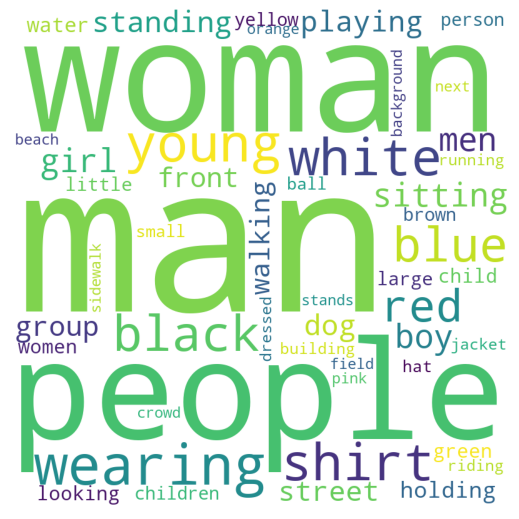

In [153]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# all stop words
stopwords = set(STOPWORDS)
# top n words
top_n = 50

# piece together all the words into a string for the wordcloud
dup_str = " ".join(dup_arr)
# get counts for all the words and sort 
dup_counts = dup_df.groupby('word')['word'] \
                    .count() \
                    .reset_index(name = 'count') \
                    .sort_values(by="count", ascending=False)

# filter out stop words
dup_counts = dup_counts[~dup_counts["word"].isin(stopwords)]
# get top_n rows 
rows_n = dup_counts.head(top_n).set_index('word')
# final words in dictionary form
rows_n_dict = rows_n.to_dict()['count']

# build the wordcloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10,
                max_words = len(rows_n_dict)).generate_from_frequencies(rows_n_dict)

# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**How often are words repeated?**